In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
#pip install sklearn

In [7]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class Distribution:
0    284315
1       492
Name: Class, dtype: int64


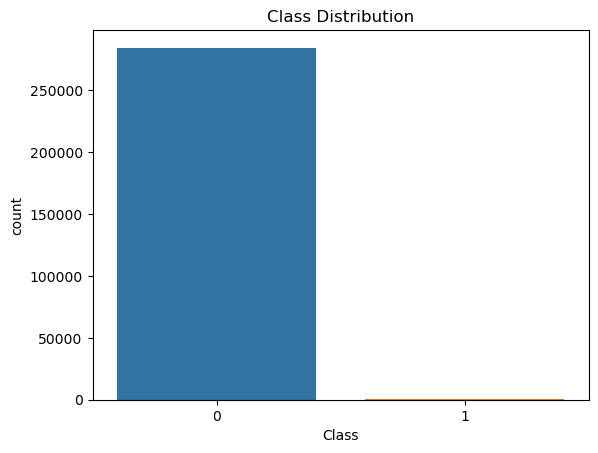

In [8]:
# Check the distribution of the target variable ('Class'):

print("Class Distribution:")
print(df['Class'].value_counts())

# Plot the class distribution
sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.show()


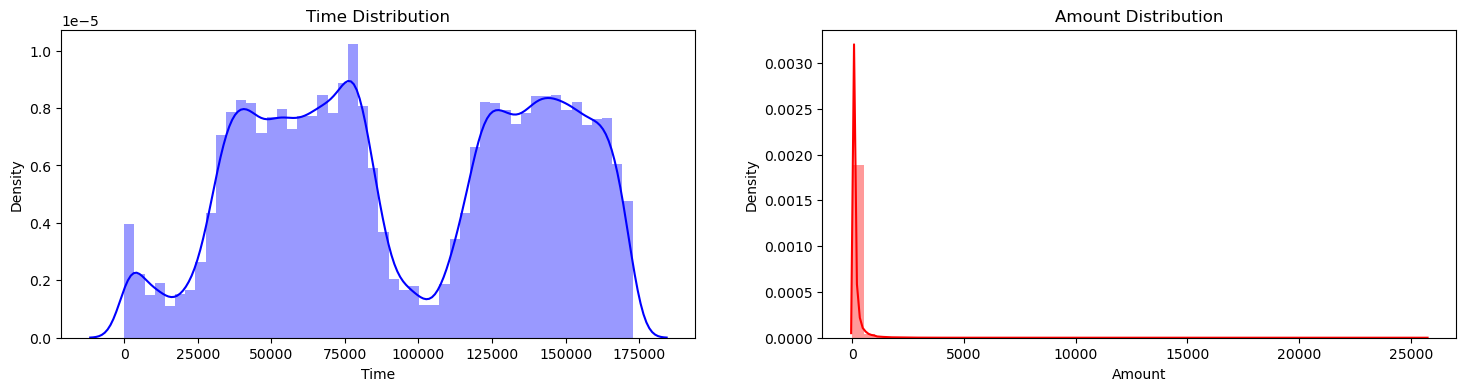

In [9]:

# Analyze the distribution of 'Time' and 'Amount' features:

fig, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.distplot(df['Time'], ax=axes[0], color='blue')
axes[0].set_title("Time Distribution")

sns.distplot(df['Amount'], ax=axes[1], color='red')
axes[1].set_title("Amount Distribution")

plt.show()


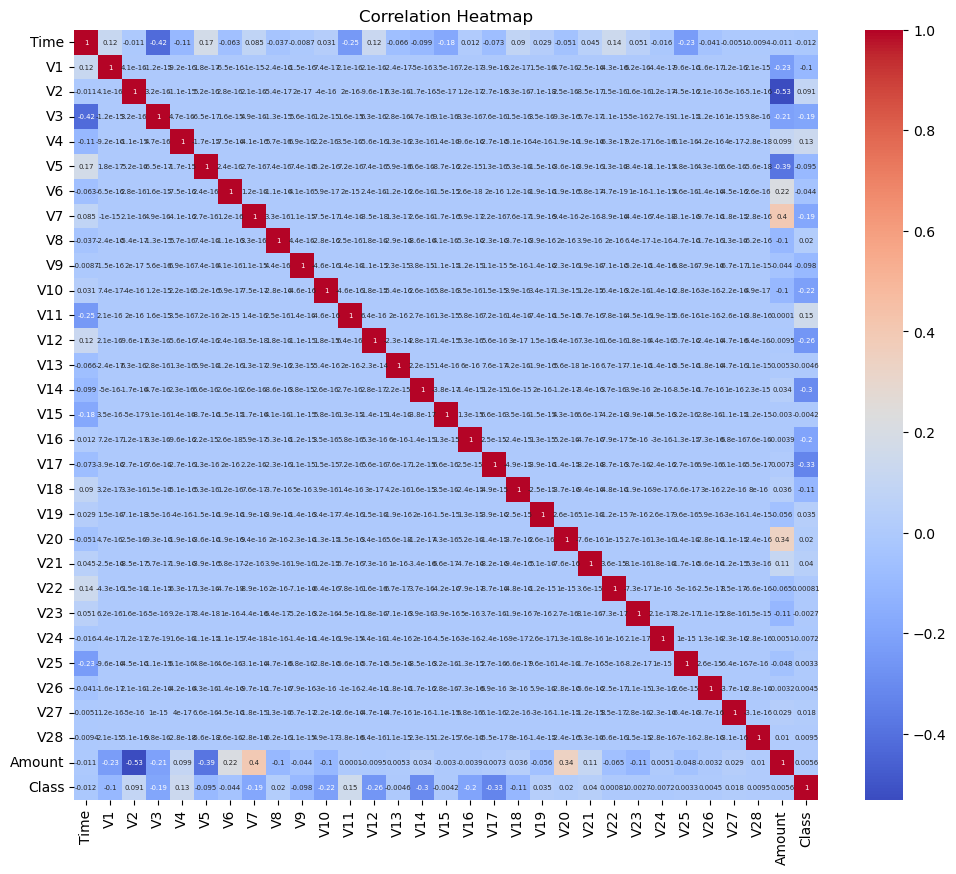

In [10]:
# Check the correlation between features:

corr_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, annot_kws={'size':5})
plt.title("Correlation Heatmap")
plt.show()





In [11]:
# Normalize the 'Time' and 'Amount' features:

scaler = StandardScaler()

df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))


In [12]:
# Split the dataset into train and test sets:

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train set and test set shapes
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (227845, 30)
Test set shape: (56962, 30)


In [ ]:
# Convert data to PyTorch tensors

X_train = torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float).unsqueeze(1)

In [ ]:
# Create a custom dataset class and data loaders:

class CreditCardDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = CreditCardDataset(X_train, y_train)
test_dataset = CreditCardDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [ ]:
# Define the LSTM model:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
# Instantiate the model, loss function, and optimizer:

model = LSTMModel(input_size=29, hidden_size=50, num_layers=1, output_size=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Train the model:

num_epochs = 10

for epoch in range(num_epochs):
    for i, (features, targets) in enumerate(train_loader):
        features = features.unsqueeze(1)
        targets = targets

        # Forward pass
        logits = model(features)
        loss = criterion(logits, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
# Evaluate the model:

model.eval()
targets_list = []
predicted_list = []

with torch.no_grad():
    for features, targets in test_loader:
        features = features.unsqueeze(1)
        targets = targets
        logits = model(features)
        predicted = torch.sigmoid(logits).round()

        targets_list.extend(targets.cpu().numpy())
        predicted_list.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(targets_list, predicted_list)
precision = precision_score(targets_list, predicted_list)
recall = recall_score(targets_list, predicted_list)
f1 = f1_score(targets_list, predicted_list)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

#